imports & setup

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
import os

# Add the fastapi directory to Python path
fastapi_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if fastapi_dir not in sys.path:
    sys.path.insert(0, fastapi_dir)

print(f"Added to path: {fastapi_dir}")
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest

from ml.data.synthetic_ts import generate_hr_spo2_sequence
from ml.inference.embed import TimeSeriesEmbedder


Added to path: c:\Users\KOUSTAV BERA\OneDrive\Desktop\chiranjeevi\fastapi


Loaded trained encoder



In [4]:
embedder = TimeSeriesEmbedder(
    model_path="../train/encoder.pt",
    latent_dim=32
)


generate validation data


In [5]:
NORMAL_SAMPLES = 120
ANOMALY_SAMPLES = 60
SEQ_LEN = 256

normal_sequences = [
    generate_hr_spo2_sequence(length=SEQ_LEN, anomaly=False)
    for _ in range(NORMAL_SAMPLES)
]

anomaly_sequences = [
    generate_hr_spo2_sequence(length=SEQ_LEN, anomaly=True)
    for _ in range(ANOMALY_SAMPLES)
]


Convert to embeddings


In [6]:
def embed_batch(sequences):
    embeddings = []
    for seq in sequences:
        seq = torch.tensor(seq.T, dtype=torch.float32)
        emb = embedder.embed(seq)
        embeddings.append(emb.squeeze())
    return np.array(embeddings)

normal_emb = embed_batch(normal_sequences)
anomaly_emb = embed_batch(anomaly_sequences)

X = np.vstack([normal_emb, anomaly_emb])
y = np.array([0] * len(normal_emb) + [1] * len(anomaly_emb))


c:\Users\KOUSTAV BERA\OneDrive\Desktop\chiranjeevi\fastapi\ml\inference\embed.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(self.device)


PCA visualisation


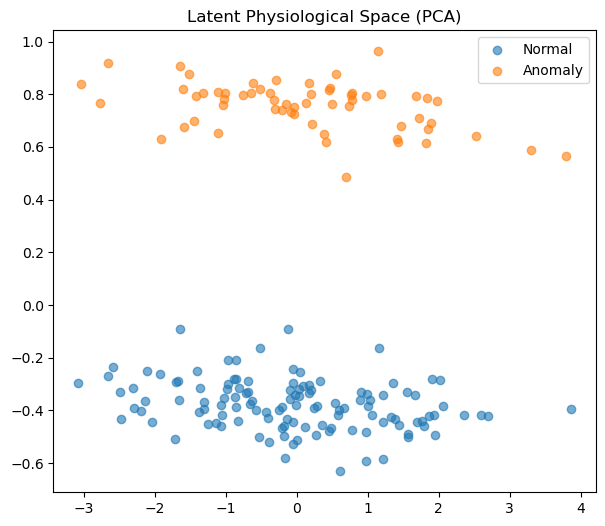

In [7]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(7, 6))
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], alpha=0.6, label="Normal")
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], alpha=0.6, label="Anomaly")
plt.title("Latent Physiological Space (PCA)")
plt.legend()
plt.show()


t-SNE visualisation

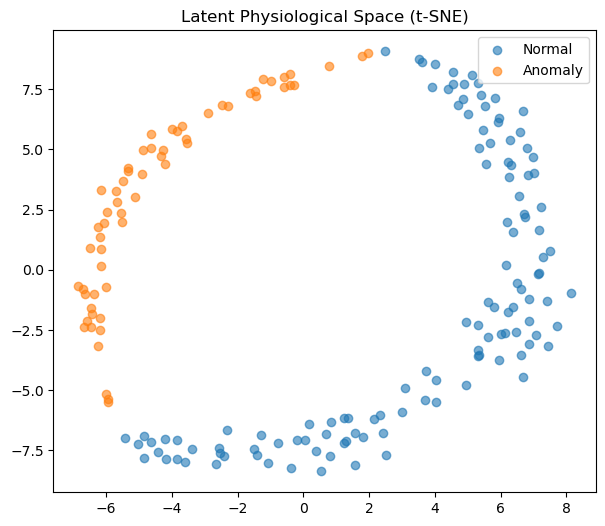

In [8]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(7, 6))
plt.scatter(X_tsne[y == 0, 0], X_tsne[y == 0, 1], alpha=0.6, label="Normal")
plt.scatter(X_tsne[y == 1, 0], X_tsne[y == 1, 1], alpha=0.6, label="Anomaly")
plt.title("Latent Physiological Space (t-SNE)")
plt.legend()
plt.show()


Train anomaly detector

In [9]:
iso = IsolationForest(
    n_estimators=200,
    contamination=0.15,
    random_state=42
)

iso.fit(normal_emb)


,n_estimators,200
,max_samples,'auto'
,contamination,0.15
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,42
,verbose,0
,warm_start,False


ANomaly Scoring

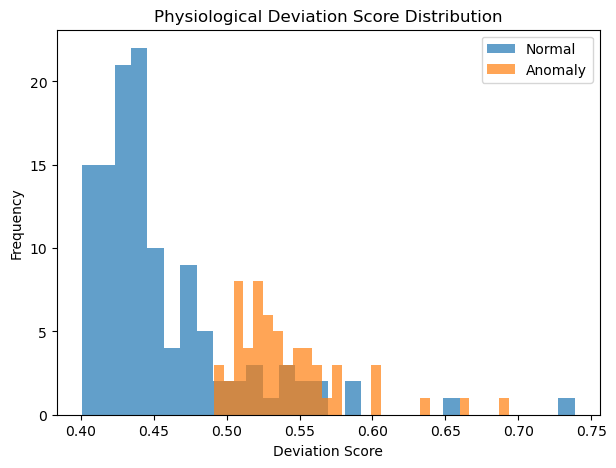

In [10]:
scores_normal = -iso.score_samples(normal_emb)
scores_anomaly = -iso.score_samples(anomaly_emb)

plt.figure(figsize=(7, 5))
plt.hist(scores_normal, bins=30, alpha=0.7, label="Normal")
plt.hist(scores_anomaly, bins=30, alpha=0.7, label="Anomaly")
plt.title("Physiological Deviation Score Distribution")
plt.xlabel("Deviation Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()


Normalize to risk score (0-100)

In [11]:
all_scores = np.concatenate([scores_normal, scores_anomaly])

s_min, s_max = all_scores.min(), all_scores.max()

def normalize_global(scores):
    return 100 * (scores - s_min) / (s_max - s_min + 1e-6)

risk_normal = normalize_global(scores_normal)
risk_anomaly = normalize_global(scores_anomaly)


print("Normal risk range:", risk_normal.min(), risk_normal.max())
print("Anomaly risk range:", risk_anomaly.min(), risk_anomaly.max())


Normal risk range: 0.0 99.99970436075881
Anomaly risk range: 26.82153322527653 86.59530899733397


Sanity check examples


In [12]:
for i in range(5):
    print(f"Normal sample {i} risk:", risk_normal[i])

for i in range(5):
    print(f"Anomaly sample {i} risk:", risk_anomaly[i])


Normal sample 0 risk: 10.97487534216609
Normal sample 1 risk: 10.919448316058613
Normal sample 2 risk: 6.517911319602228
Normal sample 3 risk: 22.718648068567425
Normal sample 4 risk: 19.947118413289953
Anomaly sample 0 risk: 36.643497853142414
Anomaly sample 1 risk: 86.59530899733397
Anomaly sample 2 risk: 44.74142963441649
Anomaly sample 3 risk: 46.44493985179277
Anomaly sample 4 risk: 35.917207946277415


In [13]:
import os
import numpy as np
import joblib
from sklearn.ensemble import IsolationForest

os.makedirs("../risk", exist_ok=True)


# Save normal embeddings
np.save("normal_embeddings.npy", normal_emb)

# Save global risk bounds
all_scores = np.concatenate([scores_normal, scores_anomaly])
s_min, s_max = all_scores.min(), all_scores.max()
# Save risk bounds
np.save("../risk/risk_bounds.npy", np.array([s_min, s_max]))
# Train & save Isolation Forest
iso = IsolationForest(
    n_estimators=200,
    contamination=0.15,
    random_state=42
)
iso.fit(normal_emb)

# Save anomaly model
joblib.dump(iso, "../risk/anomaly_model.joblib")


['../risk/anomaly_model.joblib']

In [14]:
import numpy as np

# For fusion training, we need per-system embedding batches.
# For PoC, we reuse normal embeddings (clean physiology manifold).

cardio_emb = normal_emb
resp_emb = normal_emb.copy()

np.save("cardio_embeddings.npy", cardio_emb)
np.save("resp_embeddings.npy", resp_emb)

print("Saved cardio_embeddings.npy and resp_embeddings.npy")


Saved cardio_embeddings.npy and resp_embeddings.npy
